<a href="https://colab.research.google.com/github/notabee/Bus-Booking-app/blob/master/MDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Dense, Concatenate, Activation,concatenate
from keras.models import Model
import pickle
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from matplotlib.pyplot import figure
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import math

In [0]:
with open('input_list', 'rb') as f:
    input_list = pickle.load(f)
with open('output_list', 'rb') as f:
    output_list = pickle.load(f)

In [23]:
bbx =[]
label = []
p_bbx = []
p_label = []
for input1, output in zip(input_list, output_list):
  for i, j in zip(input1, output):
    if np.array_equal([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], i):
      label.append(i)
      p_bbx.append(np.array([-1,-1,1,1]))
      p_label.append(np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
      bbx.append(j)
len(bbx)

1356

In [0]:
bbx = np.asarray(bbx, dtype = 'float32')
p_bbx = np.asarray(p_bbx, dtype = 'float32')
p_label = np.asarray(p_label )
label = np.asarray(label)

In [0]:
x = []
y = []
h = []
w = []
bbx1=[]
for i in range(0, bbx.shape[0]):
  xmin, ymin, xmax, ymax = bbx[i]
  x.append(xmin)
  y.append(ymin)
  h.append(ymax-ymin)
  w.append(xmax-xmin)
  bbx1.append([xmin, ymin, ymax-ymin, xmax-xmin])

x = np.asarray(x, dtype ='float32')
y = np.asarray(y, dtype ='float32')
h = np.asarray(h, dtype ='float32')
w = np.asarray(w, dtype ='float32')
bbx1 = np.asarray(bbx1, dtype='float32')

In [0]:
def sigma_act(x):
  
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.tanh(x) + 1)/2

In [80]:
components = 7
no_parameters = 3

inputA = Input(shape=(4,))
inputB = Input(shape=(19,))
inputC = Input(shape=(19,))

x = Dense(4, activation="relu")(inputA)
x = Model(inputs=inputA, outputs=x)

y = Dense(4, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)

z = Dense(4, activation="relu")(inputC)
z = Model(inputs=inputC, outputs=z)

combined = concatenate([x.output, y.output, z.output])

h2 = Dense(12, activation="relu")(combined)

alphasx = Dense(components, activation="softmax", name="alphasx")(h2)
musx = Dense(components, activation='tanh',name="musx")(h2)
sigmasx = Dense(components, activation=sigma_act, name="sigmasx")(h2)

x_param = Concatenate(name="x_param")([alphasx, musx, sigmasx])

alphasy = Dense(components, activation="softmax", name="alphasy")(x_param)
musy = Dense(components, activation='tanh',name="musy")(x_param)
sigmasy = Dense(components, activation=sigma_act, name="sigmasy")(x_param)

xy_param = Concatenate(name="xy_param")([alphasx, alphasy, musx, musy, sigmasx, sigmasy])

alphash = Dense(components, activation="softmax", name="alphash")(xy_param)
mush = Dense(components,activation='sigmoid', name="mush")(xy_param)
sigmash = Dense(components, activation='sigmoid', name="sigmash")(xy_param)

alphasw = Dense(components, activation="softmax", name="alphasw")(alphash)
musw = Dense(components,activation='sigmoid', name="musw")(mush)
sigmasw = Dense(components, activation='sigmoid', name="sigmasw")(sigmash)


pvector = Concatenate(name="output")([alphasx, musx, sigmasx,
                                      alphasy, musy, sigmasy,
                                      alphash, mush, sigmash,
                                      alphasw, musw, sigmasw])



model = Model(inputs=[x.input, y.input, z.input], outputs=pvector)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 19)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 19)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 4)            20          input_10[0][0]                   
__________________________________________________________________________________________________
dense_14 (

In [0]:
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(yt, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    x,y,h,w = [yt[:,i*1:(i+1)*1] for i in range(4)]
    x_vector, y_vector, h_vector, w_vector = [parameter_vector[:,i*21:(i+1)*21] for i in range(4)]
    
    alphasx, musx, sigmasx = slice_parameter_vectors(x_vector)    
    alphasy, musy, sigmasy = slice_parameter_vectors(y_vector)
    alphash, mush, sigmash = slice_parameter_vectors(h_vector)
    alphasw, musw, sigmasw = slice_parameter_vectors(w_vector)
    
    gmx = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasx),
        components_distribution=tfd.Normal(
            loc=musx,       
            scale=sigmasx))
    
    gmy = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasy),
        components_distribution=tfd.Normal(
            loc=musy,       
            scale=sigmasy))
    
    gmh = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphash),
        components_distribution=tfd.Normal(
            loc=mush,       
            scale=sigmash))
    
    gmw = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasw),
        components_distribution=tfd.Normal(
            loc=musw,       
            scale=sigmasw))
    
    log_likelihoodx = gmx.log_prob(tf.transpose(x))
    log_likelihoody = gmy.log_prob(tf.transpose(y))
    log_likelihoodh = gmh.log_prob(tf.transpose(h))
    log_likelihoodw = gmw.log_prob(tf.transpose(w))

    return -tf.reduce_mean(log_likelihoodx + log_likelihoody + log_likelihoodh + log_likelihoodw , axis=-1)

In [88]:
optimizer = Adam(lr = 0.0001)
model.compile(loss=gnll_loss, optimizer=optimizer)
d_loss = model.fit([p_bbx, p_label, label], bbx1, epochs=200, batch_size=32,shuffle=False)
print(d_loss)

Epoch 1/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5324
Epoch 2/200
1356/1356 [==============================] - 1s 462us/step - loss: 0.5317
Epoch 3/200
1356/1356 [==============================] - 1s 469us/step - loss: 0.5317
Epoch 4/200
1356/1356 [==============================] - 1s 463us/step - loss: 0.5317
Epoch 5/200
1356/1356 [==============================] - 1s 457us/step - loss: 0.5317
Epoch 6/200
1356/1356 [==============================] - 1s 461us/step - loss: 0.5317
Epoch 7/200
1356/1356 [==============================] - 1s 461us/step - loss: 0.5317
Epoch 8/200
1356/1356 [==============================] - 1s 456us/step - loss: 0.5317
Epoch 9/200
1356/1356 [==============================] - 1s 461us/step - loss: 0.5317
Epoch 10/200
1356/1356 [==============================] - 1s 461us/step - loss: 0.5317
Epoch 11/200
1356/1356 [==============================] - 1s 456us/step - loss: 0.5317
Epoch 12/200
1356/1356 [==============================

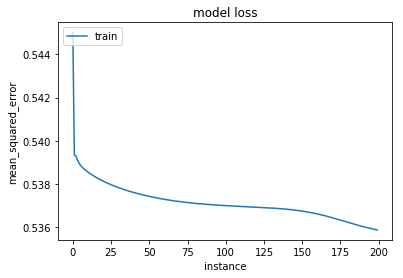

In [87]:
plt.plot(d_loss.history['loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error')
plt.xlabel('instance')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
def sampler(parameter_vector):

    x_vector, y_vector, h_vector, w_vector = [parameter_vector[:,i*21:(i+1)*21] for i in range(4)]
    
    alphasx, musx, sigmasx = slice_parameter_vectors(x_vector)    
    alphasy, musy, sigmasy = slice_parameter_vectors(y_vector)
    alphash, mush, sigmash = slice_parameter_vectors(h_vector)
    alphasw, musw, sigmasw = slice_parameter_vectors(w_vector)
    
    gmx = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasx),
        components_distribution=tfd.Normal(
            loc=musx,       
            scale=sigmasx))
    
    gmy = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasy),
        components_distribution=tfd.Normal(
            loc=musy,       
            scale=sigmasy))
    
    gmh = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphash),
        components_distribution=tfd.Normal(
            loc=mush,       
            scale=sigmash))
    
    gmw = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphasw),
        components_distribution=tfd.Normal(
            loc=musw,       
            scale=sigmasw))
    
    x = gmx.sample(1000)
    y = gmy.sample(1000)
    h = gmh.sample(1000)
    w = gmw.sample(1000)

    return x,y,h+y,w+x

In [0]:
pb = np.expand_dims(p_bbx[0], axis =0)
pl = np.expand_dims(p_label[0], axis =0)
cl = np.expand_dims(label[0], axis =0)

pred = model.predict([pb, pl, cl])

In [0]:
p1 = np.asarray([sampler(pred)])

In [0]:
pxn = tf.Session().run(p1[0][0])
pyn = tf.Session().run(p1[0][1])
pxm = tf.Session().run(p1[0][2])
pym = tf.Session().run(p1[0][3])

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


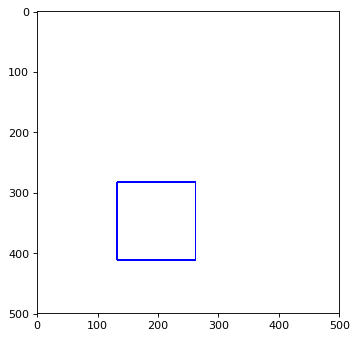

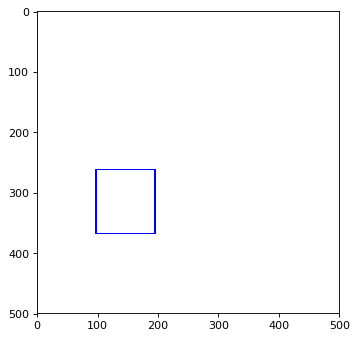

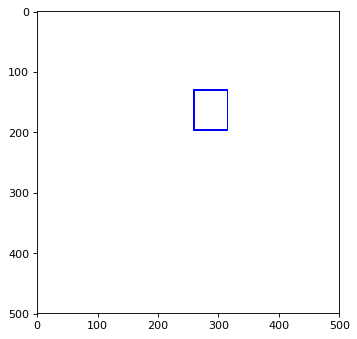

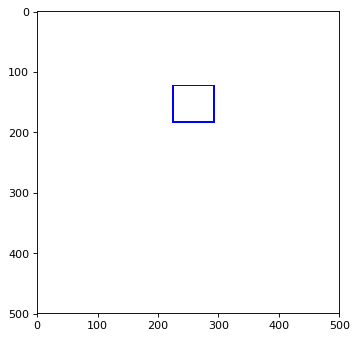

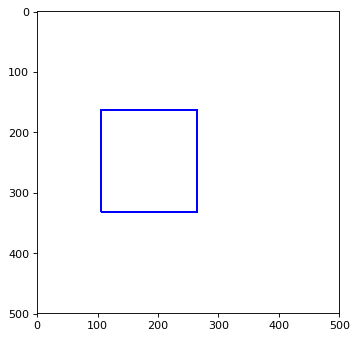

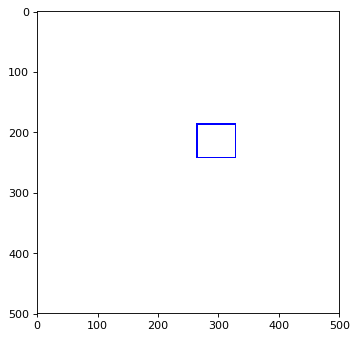

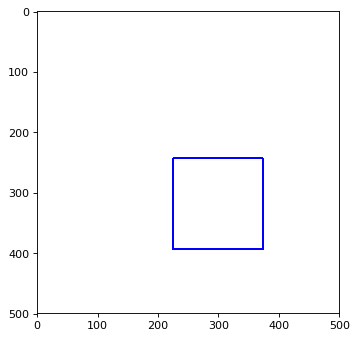

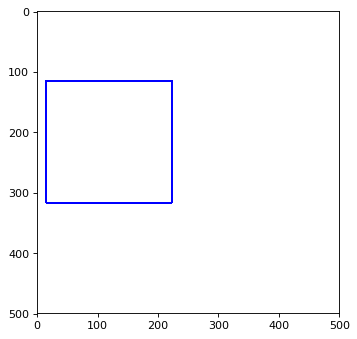

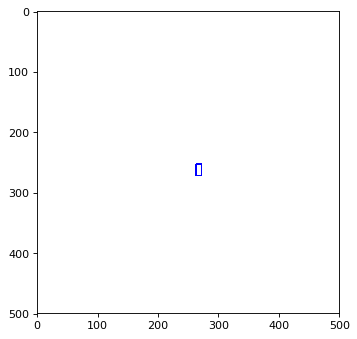

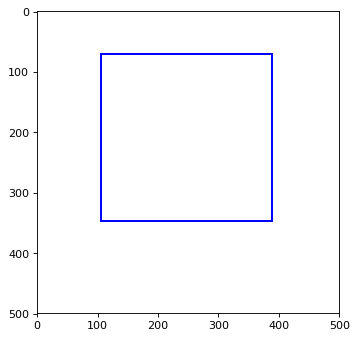

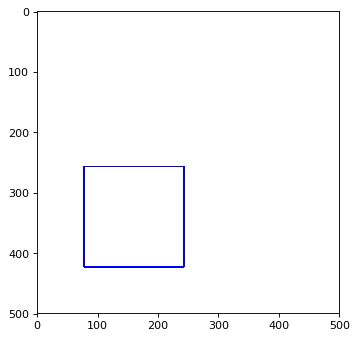

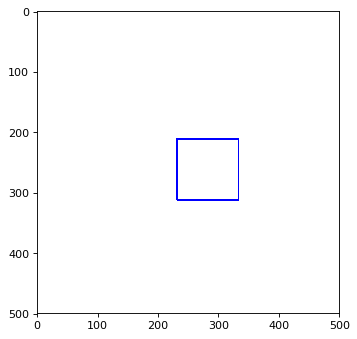

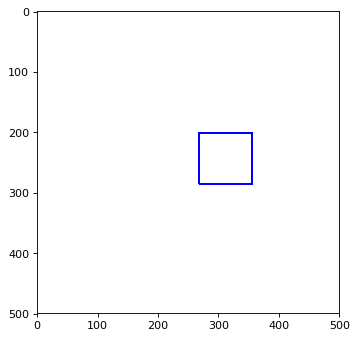

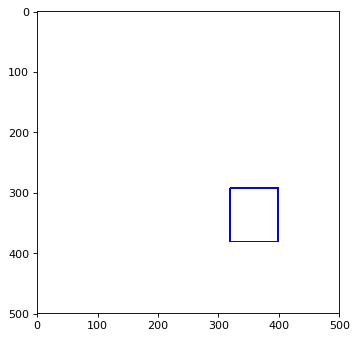

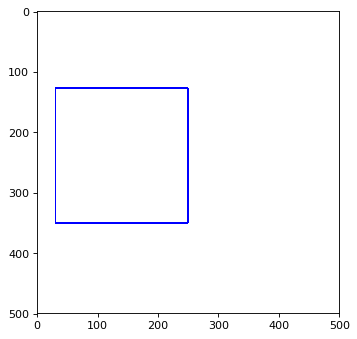

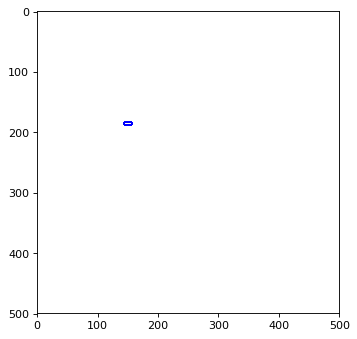

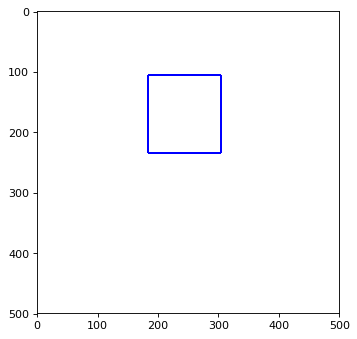

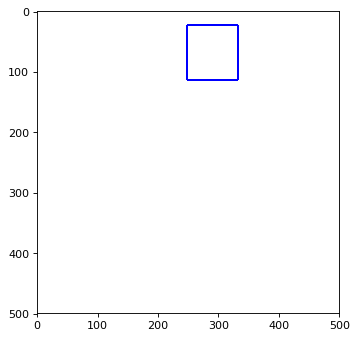

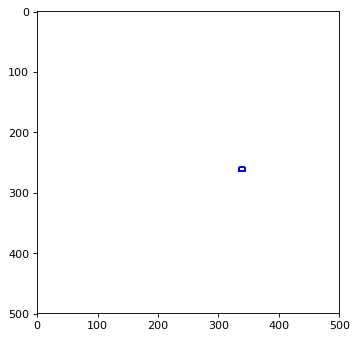

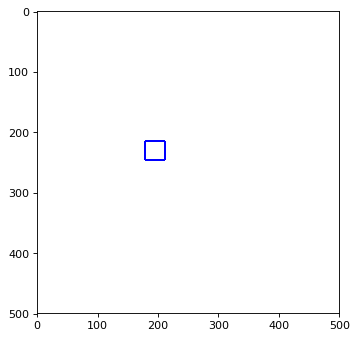

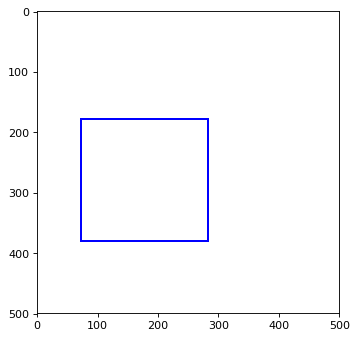

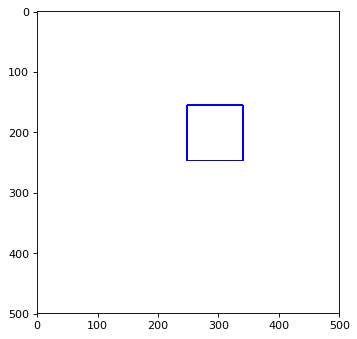

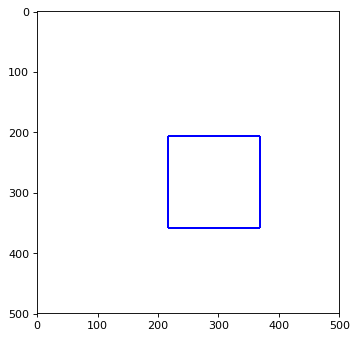

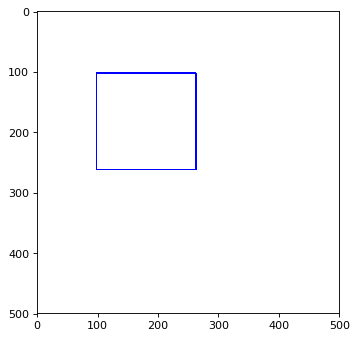

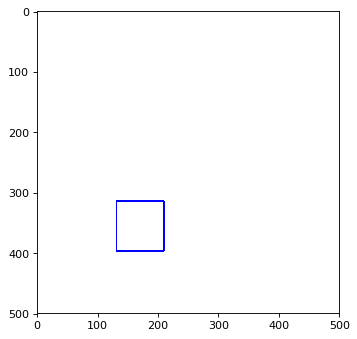

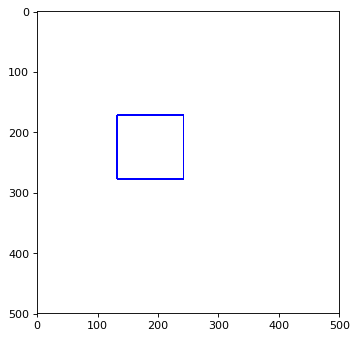

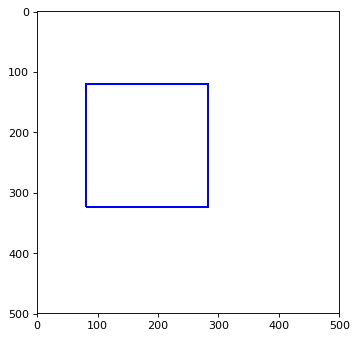

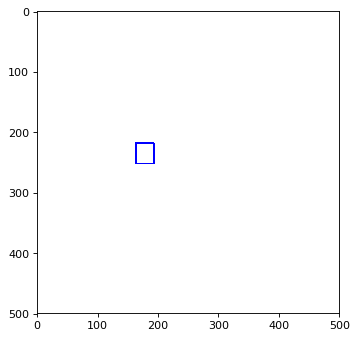

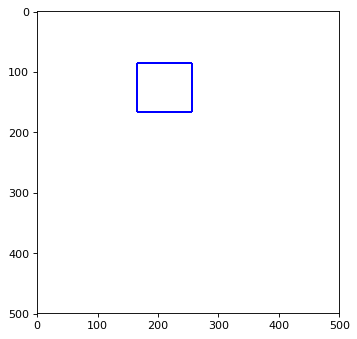

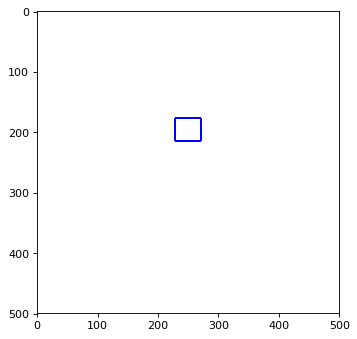

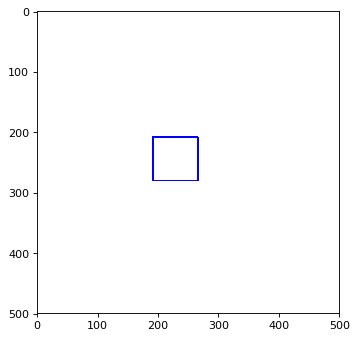

In [153]:
for xn,yn,xm,ym in zip(pxn, pyn , pxm, pym):
  p1 = np.array([xn, yn , xm, ym])
  p1 = np.reshape(p1, (1,4))
  p1 = p1 + 1
  p1 = p1*300
  canvas = np.ones((500,500,3), np.uint8) * 255
  x_minp, y_minp,x_maxp , y_maxp = p1[0]
  hh = y_maxp - y_minp
  ww = x_maxp - x_minp
  if hh >=ww-10 and hh <=ww + 10 and x_minp < 500 and y_minp < 500 and x_maxp < 500 and y_maxp < 500:
    canvas = np.ones((500,500,3), np.uint8) * 255
    cv2.rectangle(canvas, ((x_minp), (y_minp)), ((x_maxp) , (y_maxp) ), (0, 0, 255), 2)
    figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(canvas)